In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os
import glob
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train_path = 'aerial-cactus-identification/train/'
classes = (0,1)
num_classes = len(classes)

In [3]:
df_train = pd.read_csv('aerial-cactus-identification/train.csv')

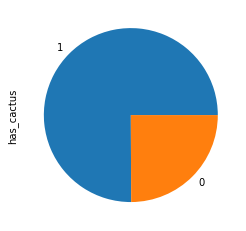

In [4]:
df_train['has_cactus'].value_counts().plot(kind='pie')

In [5]:
class cactusTrainData(Dataset): 
    def __init__(self, df, train_path = 'aerial-cactus-identification/train/', transform=None):
        self.data = df
        self.train_path = train_path
        self.transform = transform
        
    def __getitem__(self, index):
        img_path = os.path.join(self.train_path,self.data['id'].values[index])
        img = Image.open(img_path)
        label = self.data['has_cactus'].values[index].tolist()
        if self.transform is not None:
            img = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()
            img = img_tensor(img) #.requires_grad_()
        return img, label
        
    def __len__(self):
        return len(self.data)

In [6]:
class cactusTestData(Dataset): 
    def __init__(self, img_path = 'aerial-cactus-identification/test/*', transform=None):
        self.img_path = glob.glob(img_path)
        self.transform = transform
        
    def __getitem__(self, index):
        img = Image.open(self.img_path[index])
        *_, label = self.img_path[index].split('/')
        if self.transform is not None:
            img = self.transform(img)
        else:
            img_tensor = transforms.ToTensor()
            img = img_tensor(img) #.requires_grad_()
        return img, label
        
    def __len__(self):
        return len(self.img_path)

In [7]:
train_transformations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

test_transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [8]:
trainset = cactusTrainData(df_train, transform=train_transformations)
testset = cactusTestData(transform=test_transformations)

In [9]:
trainset, valset = train_test_split(trainset, test_size=0.2, random_state=42)

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=0)

In [11]:
valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=0)

In [12]:
class NeuNet(nn.Module):
    def __init__(self):
        super(NeuNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, padding=1)
        self.drop1 = nn.Dropout(p=0.2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2)
        self.fc1 = nn.Linear(in_features= 8 * 8 * 24, out_features=10)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=10, out_features=2)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.dropout(self.drop(x), training=self.training)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.dropout(self.drop(x), training=self.training)
        x = self.relu2(x)
        x = self.pool(x)
        x = x.view(-1, 8 * 8 * 24)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        return x

In [13]:
net = NeuNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [14]:
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        img, label = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(img)
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.289
[2,  2000] loss: 0.167
[3,  2000] loss: 0.132
[4,  2000] loss: 0.129
[5,  2000] loss: 0.113
[6,  2000] loss: 0.104
[7,  2000] loss: 0.102
[8,  2000] loss: 0.095
[9,  2000] loss: 0.087
[10,  2000] loss: 0.086
Finished Training


In [15]:
class_correct = list(0. for i in range(num_classes))
class_total = list(0. for i in range(num_classes))
with torch.no_grad():
    #i=0
    for data in valloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        """if i < 3:
            print(outputs)
            print(predicted)
            i+=1
        else:
            break"""
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(num_classes):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98 %
Accuracy of     1 : 95 %


In [16]:
pre_sub = []
file_sub = []
with torch.no_grad():
    #i = 0
    for data in testloader:
        images, file = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        """if i < 3:
            print(outputs)
            print(predicted)
            i+=1
        else:
            break"""
        
        for jpg, pre in zip(file, predicted.tolist()):
            pre_sub.append(pre)
            file_sub.append(jpg)

In [17]:
submission_dict = {'id':file_sub,'has_cactus':pre_sub}

df_sub = pd.DataFrame(submission_dict)
df_sub.set_index('id', inplace=True)

In [18]:
df_sub.sort_index(inplace=True)
df_compare = pd.read_csv('submission.csv')
df_compare.loc[df_compare['has_cactus'] >= 0.5,'has_cactus'] = 1
df_compare.loc[df_compare['has_cactus'] < 0.5,'has_cactus'] = 0
df_compare.set_index('id', inplace=True)
df_compare.sort_index(inplace=True)
df_tmp = df_sub == df_compare
df_tmp[df_tmp['has_cactus']==False];

In [19]:
print(str(100 -len(df_tmp[df_tmp['has_cactus']==False])/len(df_sub)*100) + '%')

94.125%


CNN Neural Network Accuracy, for the test data, is listed above

In [20]:
PATH = './cactus_e10.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
model = NeuNet()
model.load_state_dict(torch.load(PATH))

In [22]:
for parameter in net.parameters():
    print(parameter.size())

torch.Size([12, 3, 3, 3])
torch.Size([12])
torch.Size([24, 12, 3, 3])
torch.Size([24])
torch.Size([10, 1536])
torch.Size([10])
torch.Size([2, 10])
torch.Size([2])


In [23]:
iter(trainloader).next()[0].size()

torch.Size([4, 3, 32, 32])

In [24]:
iter(testloader).next()[0].size()

torch.Size([4, 3, 32, 32])

In [29]:
for i in range(15000):
    if i % 5000 == 4999:
        print(i+1)

5000
10000
15000
